In [1]:
import pandas as pd
import warnings
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rcParams
import datetime

# calling functions from the util.py file
from util import (
    sessions_final_df_cleaning,
    countplot_viz,
    distplot_viz,
    countplot_viz_unlimit,
    countplot_pointplot_viz,
)

from datetime import datetime
from datetime import timedelta


# ignoring warnings
warnings.filterwarnings("ignore")

pd.options.display.max_columns = None

# adding useful magic functions
%load_ext lab_black
%matplotlib inline
%config Completer.use_jedi = False

In [2]:
# Uploading data set
df_data = pd.read_csv("mondu_fraud_case_study.csv")

In [3]:
df_data.head()

,account_age_days,transaction_amt,transaction_adj_amt,historic_velocity,ip_address,user_agent,email_domain,phone_number,billing_city,billing_postal,billing_state,card_bin,currency,cvv,signature_image,transaction_type,transaction_env,EVENT_TIMESTAMP,applicant_name,billing_address,merchant_id,locale,tranaction_initiate,days_since_last_logon,inital_amount,EVENT_LABEL
0,3371.0,2167.0,56.0,2572.0,154.68.49.124,Opera/9.81.(Windows NT 10.0; ht-HT) Presto/2.9...,perez-garza.com,878-111-5140,Woodsburgh,96336.0,California,40771.0,cad,D,F,U,X,29.12.20 09:05,Linda Wright,4684 Sharon Ranch,066-82-8795,niu_NZ,O,59.0,13646.0,legit
1,2714.0,2045.0,48.0,4517.0,39.131.125.85,Opera/9.76.(X11; Linux i686; mi-NZ) Presto/2.9...,mcneil-ortega.com,(002)736-0139,West Kevin,78083.0,Florida,24480.0,cad,X,X,H,W,22.06.21 18:05,Terri Rivera,7642 Allison Ramp,669-99-9459,apn_IN,J,0.0,11930.0,legit
2,6987.0,2892.0,61.0,5007.0,166.245.194.83,Mozilla/5.0 (X11; Linux x86_64; rv:1.9.6.20) G...,davis-calderon.com,(983)585-2863x652,Lorichester,83236.0,Utah,37778.0,cad,X,Q,X,X,10.05.21 13:48,Sarah Gray,4948 Lisa Passage,086-41-1624,dv_MV,T,83.0,7412.0,legit
3,2712.0,3040.0,28.0,6022.0,100.1.217.216,Mozilla/5.0 (Macintosh; Intel Mac OS X 10 9_3 ...,rose-lee.org,+1-678-897-3420x60738,Stephenmouth,78364.0,Virginia,55790.0,usd,G,G,C,N,11.03.21 07:36,Valerie Jenkins,1616 Little Camp,669-97-4021,byn_ER,M,24.0,4623.0,legit
4,3598.0,2976.0,66.0,2600.0,113.156.65.245,Mozilla/5.0 (X11; Linux x86_64; rv:1.9.5.20) G...,nash.net,(013)204-1766x92641,New Brianmouth,77499.0,South Carolina,37370.0,cad,X,F,F,G,27.03.21 06:13,Amy Coleman,149 Harris Rapid,088-21-6329,the_NP,K,21.0,1905.0,legit


In [4]:
df_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150000 entries, 0 to 149999
Data columns (total 26 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   account_age_days       149892 non-null  float64
 1   transaction_amt        149870 non-null  float64
 2   transaction_adj_amt    149886 non-null  float64
 3   historic_velocity      149885 non-null  float64
 4   ip_address             149873 non-null  object 
 5   user_agent             149887 non-null  object 
 6   email_domain           149910 non-null  object 
 7   phone_number           149873 non-null  object 
 8   billing_city           149884 non-null  object 
 9   billing_postal         149876 non-null  float64
 10  billing_state          149887 non-null  object 
 11  card_bin               149872 non-null  float64
 12  currency               149892 non-null  object 
 13  cvv                    149877 non-null  object 
 14  signature_image        149895 non-nu

In [5]:
# Adding new column for using in the rate calculations:

df_data["EVENT_LABEL_"] = np.where(df_data["EVENT_LABEL"] == "fraud", 1, 0)

## Understanding Variables:
### Target Varible: Event Label

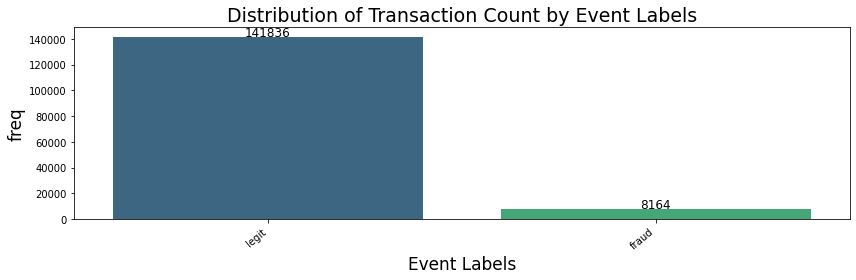

In [6]:
# Distribution of transaction counts by whether fraud or not:

countplot_viz(
    df_data,
    "EVENT_LABEL",
    "Event Labels",
    "freq",
    "Distribution of Transaction Count by Event Labels",
    figsize_x=12,
    figsize_y=4,
    palette="viridis",
)

In [7]:
print(
    "Fraud rate:\n--------------------------\n",
    round(8164 / (141836 + 8164), 4),
)

Fraud rate:
--------------------------
 0.0544


* There are 2 different categories as the event labels: Fraud and Legit
* Rate of the fraudelent activities into total activities is 0.0544. 

### Bivariate Relationships: Time Variables
### Event Timestamp & Event Label

In [8]:
# Changing type of EVENT_TIMESTAMP column from object to datetime:

df_data["EVENT_TIMESTAMP"] = pd.to_datetime(df_data["EVENT_TIMESTAMP"])

In [9]:
# Adding new columns as years, months, weekdays, hours and days.

df_data["Weekday"] = df_data[
    "EVENT_TIMESTAMP"
].dt.dayofweek  # To see Weekdays of the week
df_data["Hour"] = df_data["EVENT_TIMESTAMP"].dt.hour  # To see hours of the day
df_data["Day"] = df_data["EVENT_TIMESTAMP"].dt.day  # To see days of the month
df_data["Year"] = df_data["EVENT_TIMESTAMP"].dt.year  # To see years of the column
df_data["Month"] = df_data["EVENT_TIMESTAMP"].dt.month  # To see months of the column

### Yearly check:

In [10]:
# To see which years we have in the dataset:

df_data["Year"].unique()

array([2020., 2021.,   nan])

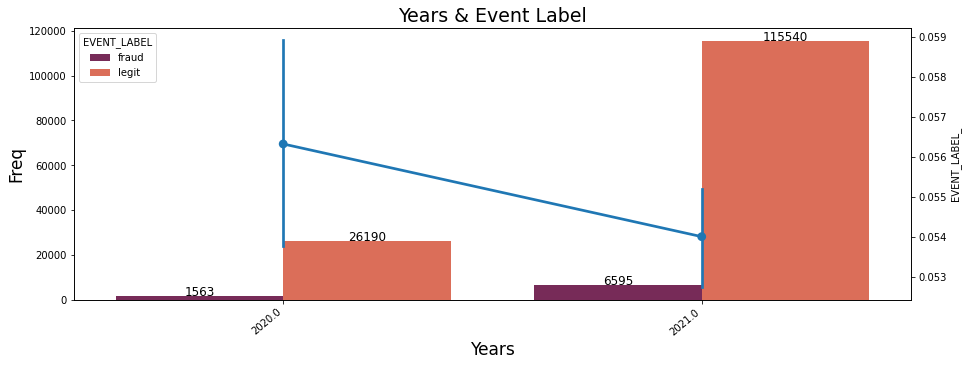

In [11]:
# To see count of fraud and legit transaction at years:

filter_list = ["fraud", "legit"]
countplot_pointplot_viz(
    df_data,
    filter_list,
    "Year",
    "EVENT_LABEL",
    "EVENT_LABEL_",
    "Years",
    "Freq",
    "Years & Event Label",
    palette="rocket",
    figsize_x=15,
    figsize_y=5,
)

### Yearly transation amount ratio is %6.5

In [12]:
df_data.groupby(by=["Year", "EVENT_LABEL"])["transaction_amt"].sum().reset_index()

,Year,EVENT_LABEL,transaction_amt
0,2020.0,fraud,4440880.0
1,2020.0,legit,65599460.0
2,2021.0,fraud,18653194.0
3,2021.0,legit,288913503.0


### Yearly transation fraud ratio is %0.5

In [13]:
df_data.groupby(by=["Year", "EVENT_LABEL"])["transaction_amt"].count().reset_index()

,Year,EVENT_LABEL,transaction_amt
0,2020.0,fraud,1563
1,2020.0,legit,26168
2,2021.0,fraud,6587
3,2021.0,legit,115440


#### Findings: 
* If we looking the count of fraudelent activities, Biggest count is belong to 2021. 
* If we looking the rate of fraudelent activities, Biggest rate is belong to 2020.
* There is big differences between ratio of fraud transaction amount and ratio of fraud transactions. It shows fraud transaction count can be small but amount of fraud transaction is bigger than legit transactions. 

### Monthly check:

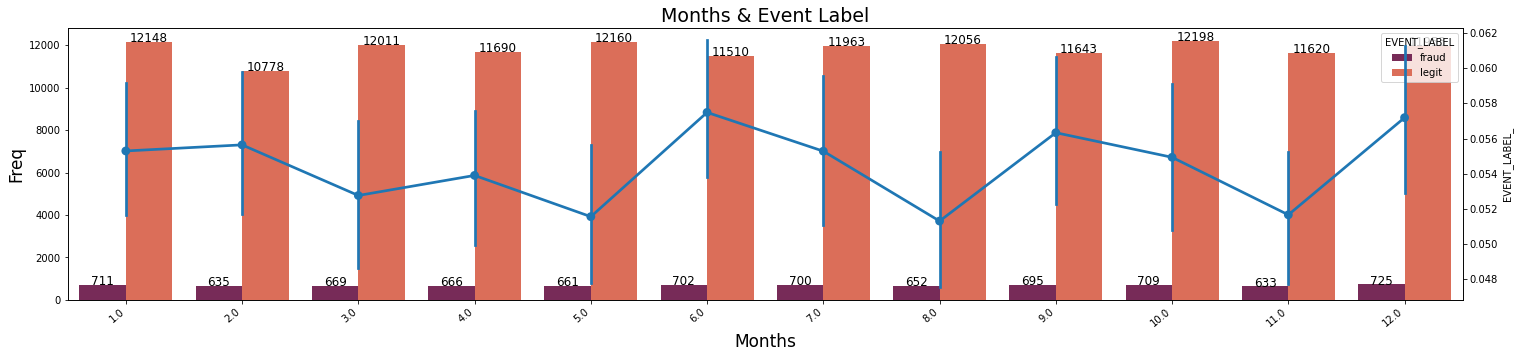

In [38]:
# To see count of fraud and legit transaction at months:

filter_list = ["fraud", "legit"]
countplot_pointplot_viz(
    df_data,
    filter_list,
    "Month",
    "EVENT_LABEL",
    "EVENT_LABEL_",
    "Months",
    "Freq",
    "Months & Event Label",
    palette="rocket",
    figsize_x=25,
    figsize_y=5,
)

#### Findings: 
 * December and June  are more open to fraudulent activities. 

### Day of the Week Check:

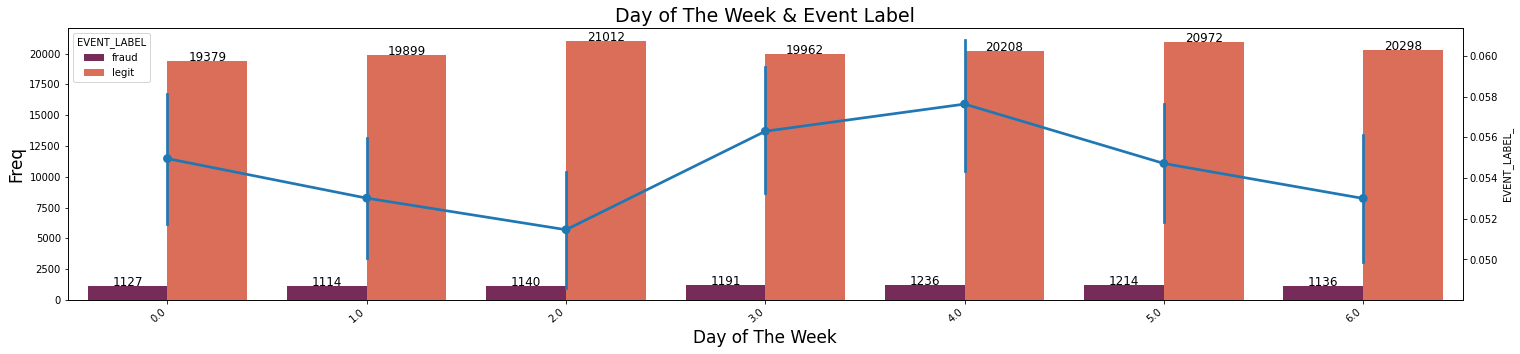

In [39]:
# The day of the week with Monday=0, Sunday=6. Return the day of the week. It is assumed the week starts on Monday, which is denoted by 0 and ends on Sunday which is denoted by 6.

filter_list = ["fraud", "legit"]
countplot_pointplot_viz(
    df_data,
    filter_list,
    "Weekday",
    "EVENT_LABEL",
    "EVENT_LABEL_",
    "Day of The Week",
    "Freq",
    "Day of The Week & Event Label",
    palette="rocket",
    figsize_x=25,
    figsize_y=5,
)

#### Findings:
* Friday has biggest count and ratio of fraudulent activities. 

#### Days of Month Check: 

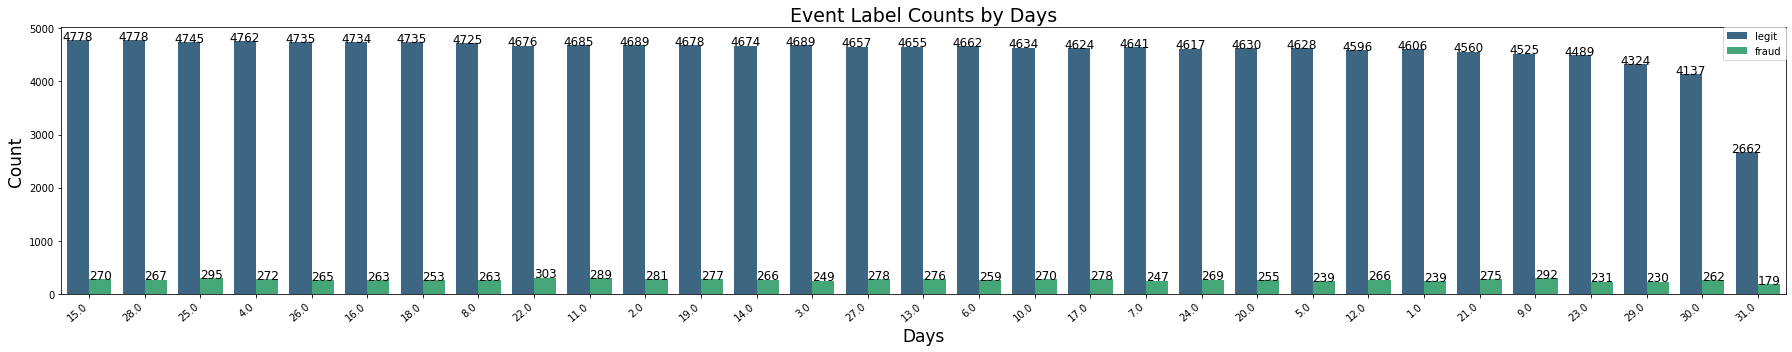

In [19]:


countplot_viz_unlimit(
    df_data,
    "Day",
    "Days",
    "Count",
    "Event Label Counts by Days",
    hue="EVENT_LABEL",
    rotation=45,
    figsize_x=25,
    figsize_y=5,
)

#### Findings: 
* 25th and 9th of month have biggest fraudelent activities. 

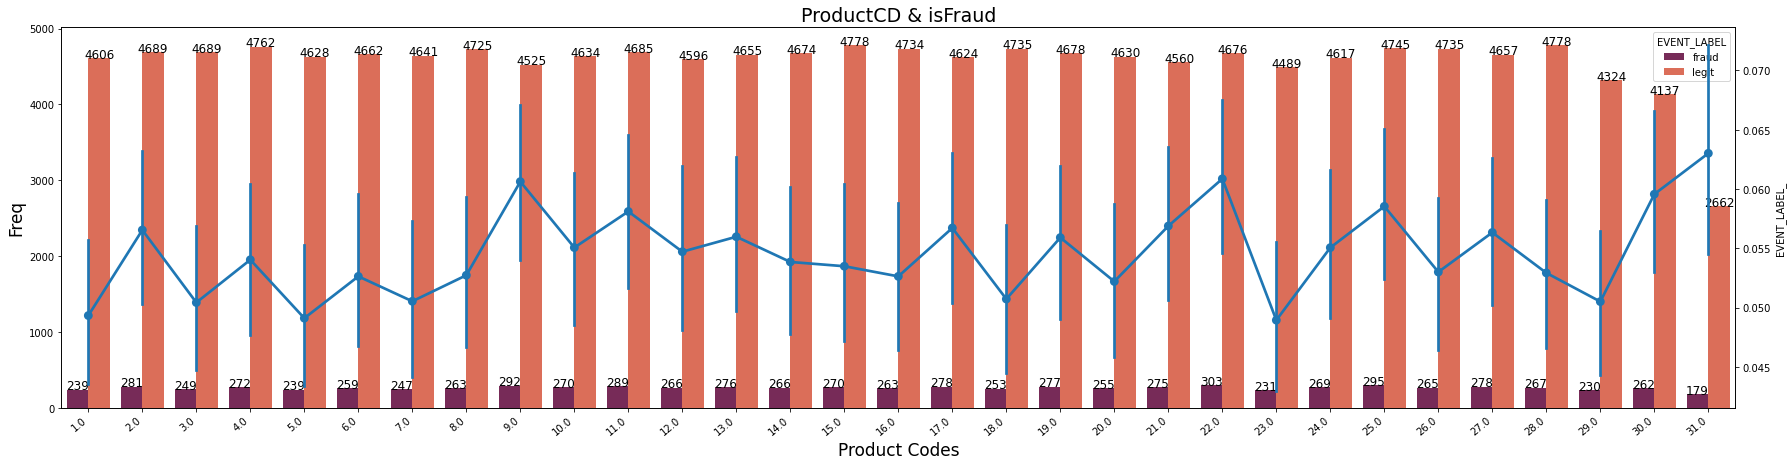

In [20]:
# The day of the months. It starts with 1 and and with 31.

filter_list = ["fraud", "legit"]
countplot_pointplot_viz(
    df_data,
    filter_list,
    "Day",
    "EVENT_LABEL",
    "EVENT_LABEL_",
    "Product Codes",
    "Freq",
    "ProductCD & isFraud",
    palette="rocket",
    figsize_x=30,
    figsize_y=7,
)

#### Hours of Day Check: 

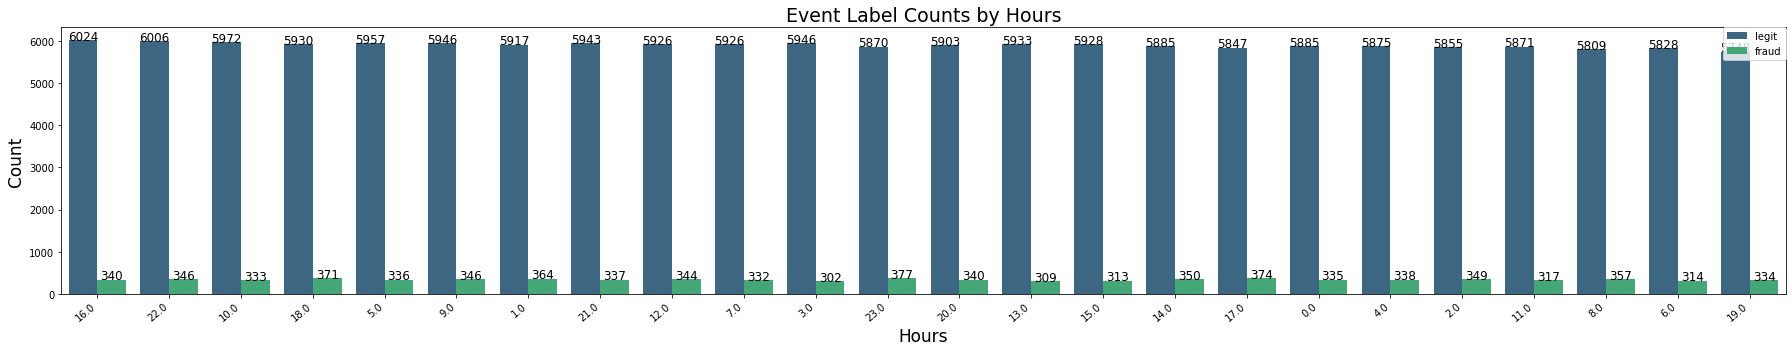

In [21]:
# The hours of day with 24pm=0.0, 1am=1.0, etc. Return the hours of the day.

countplot_viz_unlimit(
    df_data,
    "Hour",
    "Hours",
    "Count",
    "Event Label Counts by Hours",
    hue="EVENT_LABEL",
    rotation=45,
    figsize_x=25,
    figsize_y=5,
)

#### Findings: 
* 23, 17 and 18 have biggest fraudelent activities. 
    * It shows late hours and after work hours is open to fraudelent activities. 

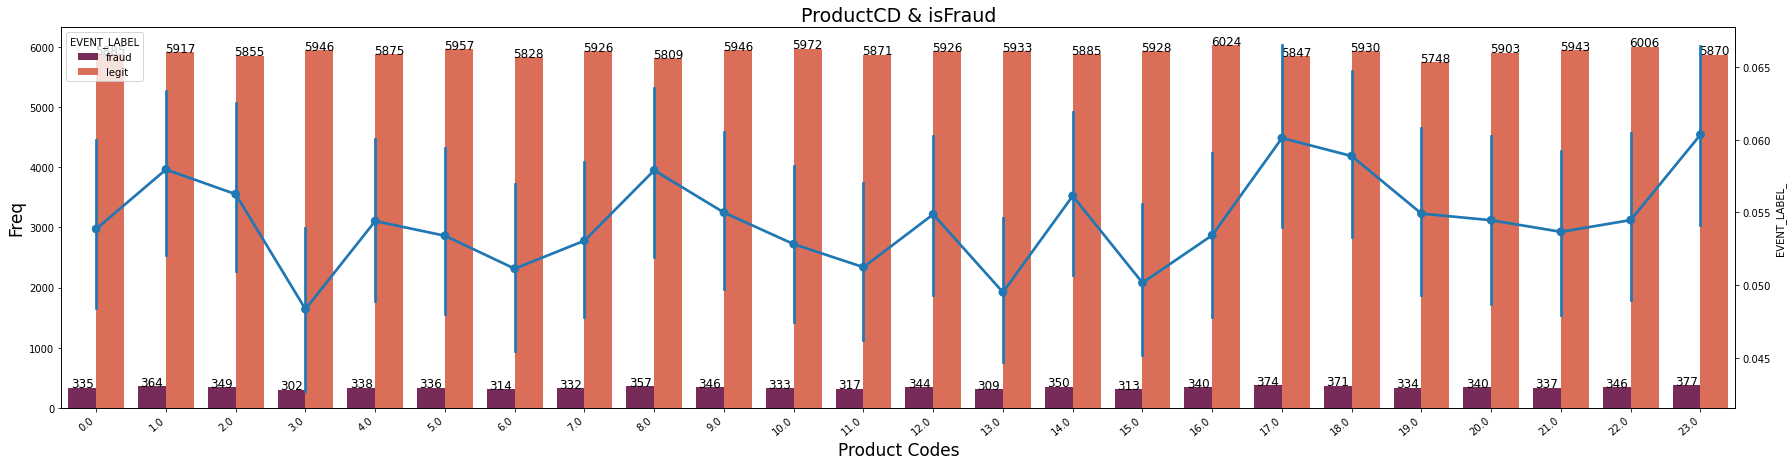

In [22]:
filter_list = ["fraud", "legit"]
countplot_pointplot_viz(
    df_data,
    filter_list,
    "Hour",
    "EVENT_LABEL",
    "EVENT_LABEL_",
    "Product Codes",
    "Freq",
    "ProductCD & isFraud",
    palette="rocket",
    figsize_x=30,
    figsize_y=7,
)

### Bivariate Relationships: Numerics Variables
### Account Age & Event Label:

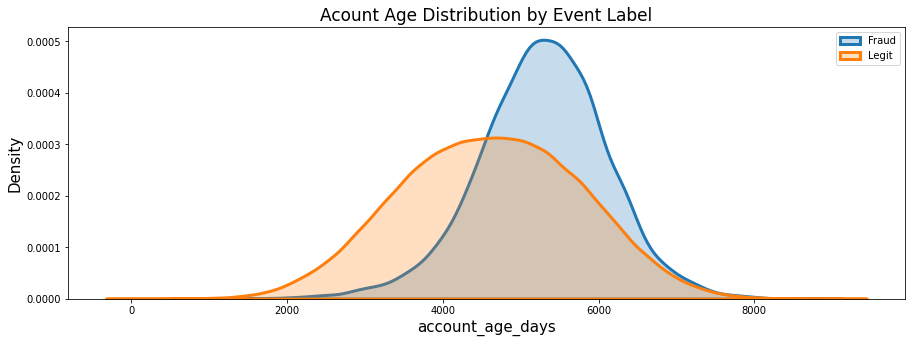

In [23]:
distplot_viz(
    data=df_data,
    column="account_age_days",
    separate_column="EVENT_LABEL",
    condition_1="fraud",
    condition_2="legit",
    label1="Fraud",
    label2="Legit",
    title="Acount Age Distribution by Event Label",
    color1="blue",
    color2="red",
)

#### Findings: 
* Fraudelent transaction mostly appeare after 4500 days.

### Transaction Amount & Event Label:

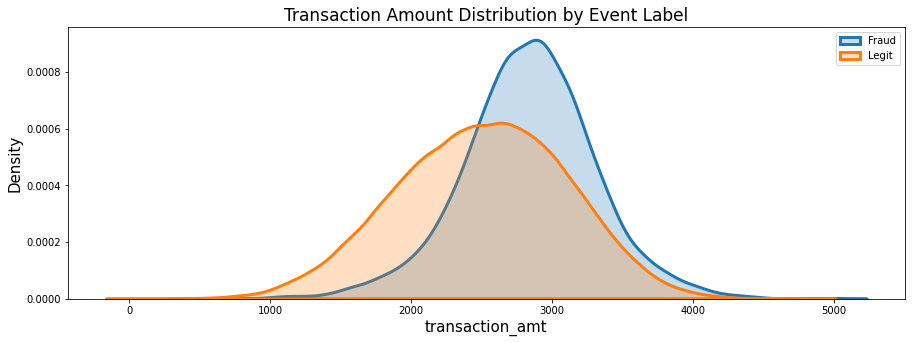

In [24]:
distplot_viz(
    data=df_data,
    column="transaction_amt",
    separate_column="EVENT_LABEL",
    condition_1="fraud",
    condition_2="legit",
    label1="Fraud",
    label2="Legit",
    title="Transaction Amount Distribution by Event Label",
    color1="blue",
    color2="red",
)

#### Findings: 
* Fraudelent transactions mostly appeare for bigger than 3000 amount purchase.

### Days Since Last Logon & Event Label:

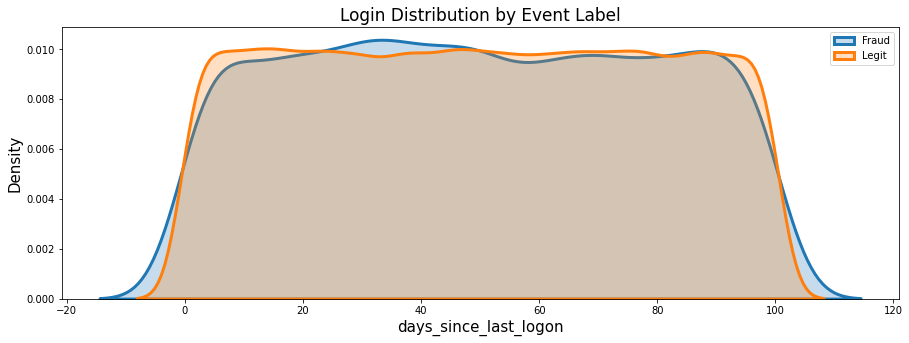

In [25]:
distplot_viz(
    data=df_data,
    column="days_since_last_logon",
    separate_column="EVENT_LABEL",
    condition_1="fraud",
    condition_2="legit",
    label1="Fraud",
    label2="Legit",
    title="Login Distribution by Event Label",
    color1="blue",
    color2="red",
)

#### Findings: 
* There is no specific differences between giving break to login or not. 

### Card Bin & Event Label: Card Bin Banka Ayraci - Numeric Degil 

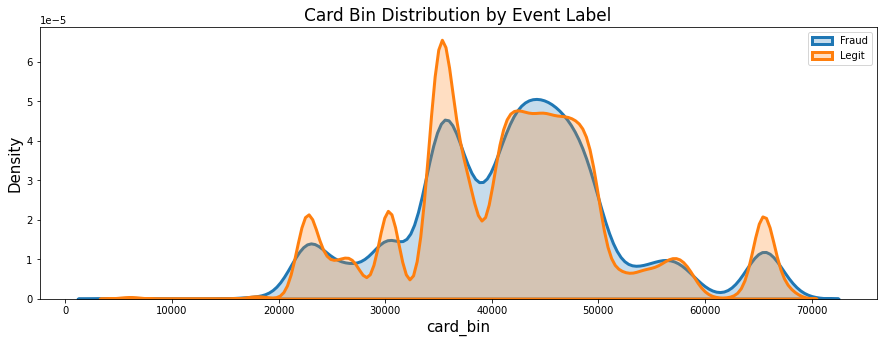

In [26]:
distplot_viz(
    data=df_data,
    column="card_bin",
    separate_column="EVENT_LABEL",
    condition_1="fraud",
    condition_2="legit",
    label1="Fraud",
    label2="Legit",
    title="Card Bin Distribution by Event Label",
    color1="blue",
    color2="red",
)

### Bivariate Relationships: Numerics Variables
### Billing States & Event Label

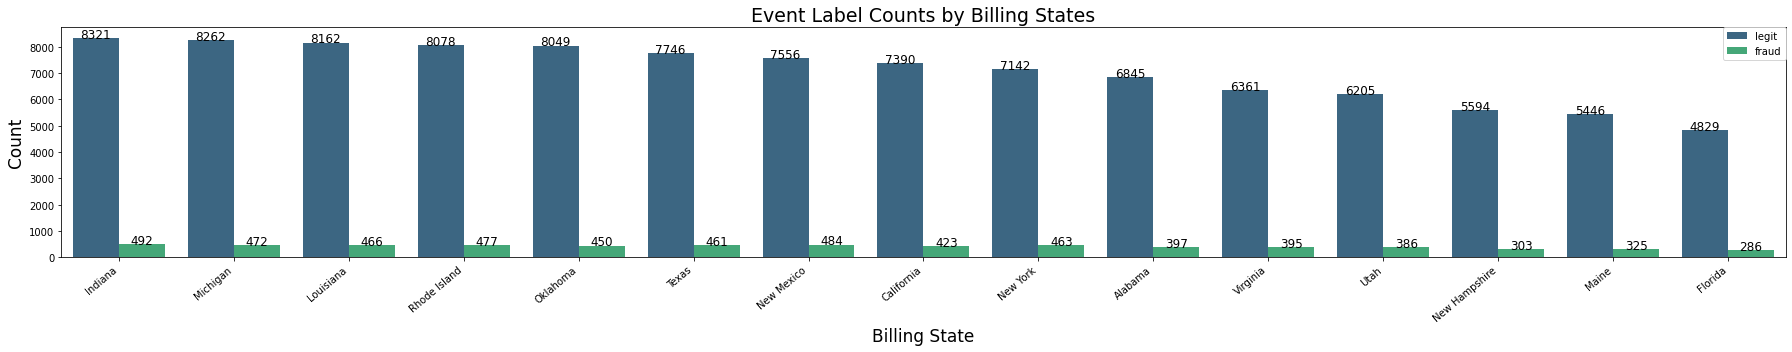

In [27]:
countplot_viz(
    df_data,
    "billing_state",
    "Billing State",
    "Count",
    "Event Label Counts by Billing States",
    hue="EVENT_LABEL",
    rotation=45,
    figsize_x=25,
    figsize_y=5,
)

#### Findings: 
* Fraudelent transactions mostly appeare at Indiana and New Mexico. 

### Currency & Event Label

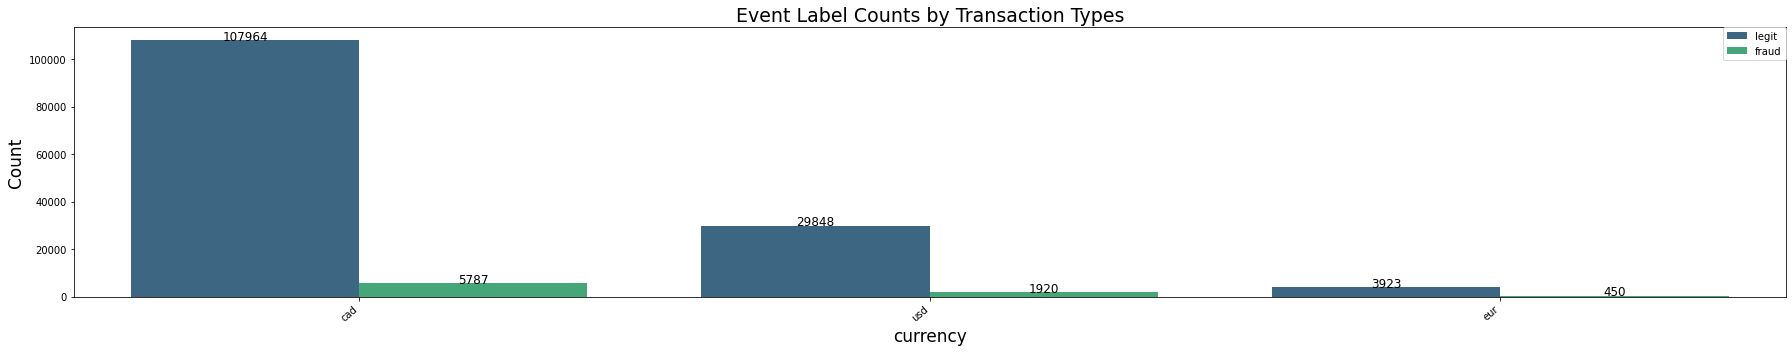

In [28]:
countplot_viz(
    df_data,
    "currency",
    "currency",
    "Count",
    "Event Label Counts by Transaction Types",
    hue="EVENT_LABEL",
    rotation=45,
    figsize_x=25,
    figsize_y=5,
)

In [29]:
print(
    "Fraud rate into cad currency:\n--------------------------\n",
    5787 / (107964 + 5787),
)
print(
    "Fraud rate into usd currency:\n--------------------------\n",
    1920 / (29848 + 1920),
)
print(
    "Fraud rate into euro currency:\n--------------------------\n",
    450 / (3923 + 450),
)

Fraud rate into cad currency:
--------------------------
 0.050874278028325025
Fraud rate into usd currency:
--------------------------
 0.06043817678166709
Fraud rate into euro currency:
--------------------------
 0.10290418477018065


#### Findings:
* If we looking the count of fraudelent activities, Biggest count is belong to cad currency. 
* If we looking the rate of fraudelent activities, Biggest rate is belong to euro currency. It shows shopping with euro currency is open to fraud. 

### Transaction Types & Event Label: 

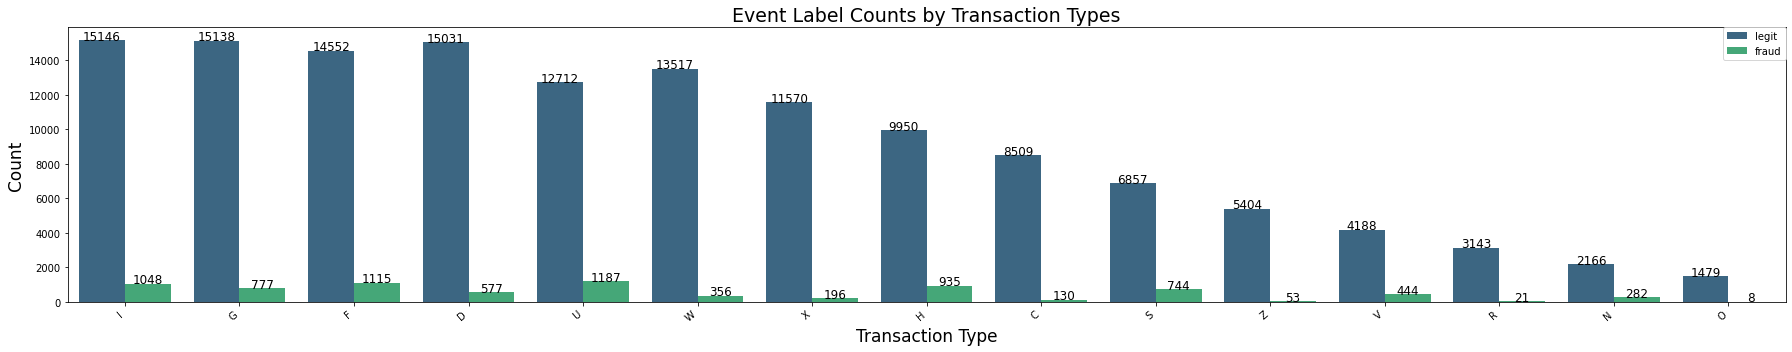

In [30]:
countplot_viz(
    df_data,
    "transaction_type",
    "Transaction Type",
    "Count",
    "Event Label Counts by Transaction Types",
    hue="EVENT_LABEL",
    rotation=45,
    figsize_x=25,
    figsize_y=5,
)

#### Findings: 
* Fraudelent transactions mostly appeare at U, F and I. 

### Transaction Env & Event Label: 

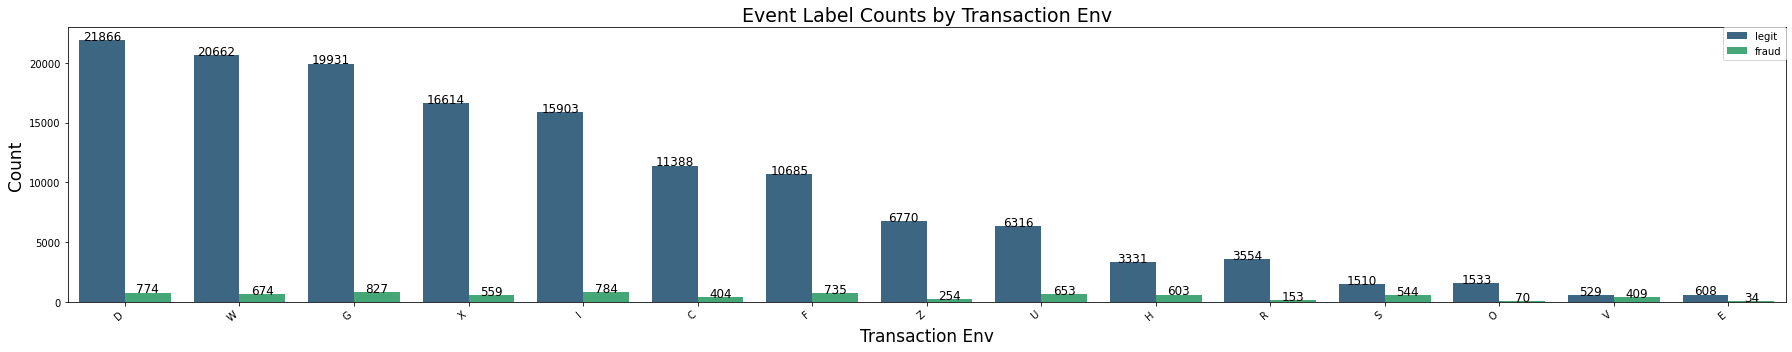

In [31]:
countplot_viz(
    df_data,
    "transaction_env",
    "Transaction Env",
    "Count",
    "Event Label Counts by Transaction Env",
    hue="EVENT_LABEL",
    rotation=45,
    figsize_x=25,
    figsize_y=5,
)

#### Findings: 
* Fraudelent transactions mostly appeare at G, I and D. 

### Transaction Initiate & Event Label: 

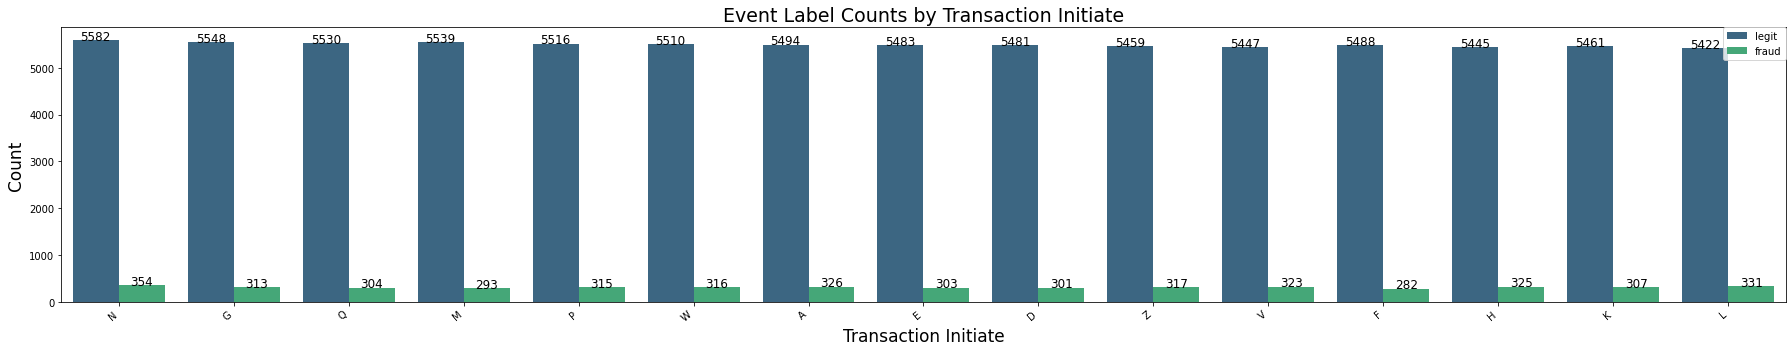

In [32]:
countplot_viz(
    df_data,
    "tranaction_initiate",
    "Transaction Initiate",
    "Count",
    "Event Label Counts by Transaction Initiate",
    hue="EVENT_LABEL",
    rotation=45,
    figsize_x=25,
    figsize_y=5,
)

#### Findings: 
* Fraudelent transactions mostly appeare at G, I and D. 

### Inital Amount & Event Label:  

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


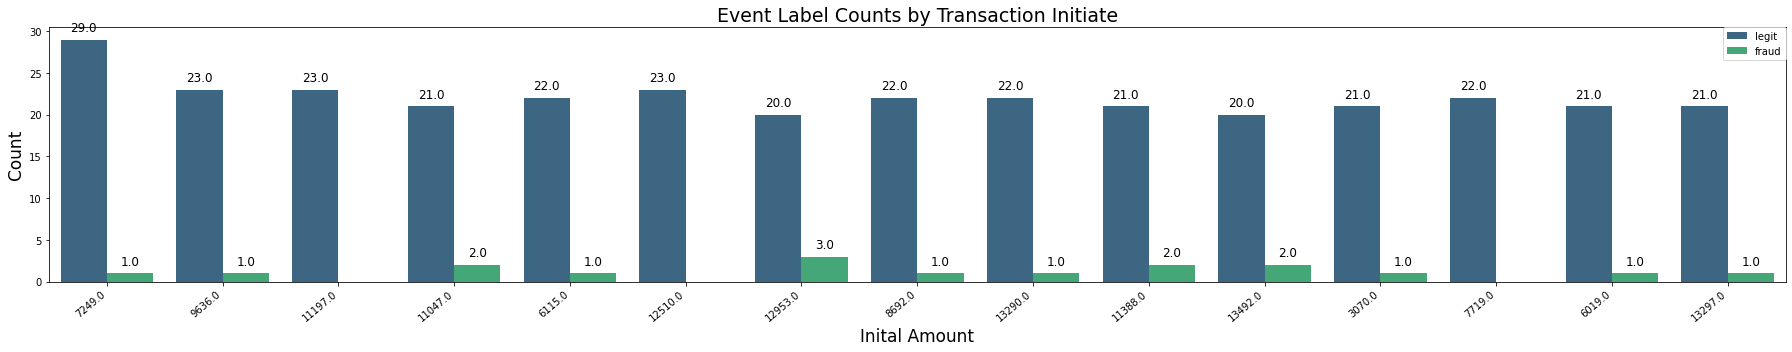

In [33]:
countplot_viz(
    df_data,
    "inital_amount",
    "Inital Amount",
    "Count",
    "Event Label Counts by Transaction Initiate",
    hue="EVENT_LABEL",
    rotation=45,
    figsize_x=25,
    figsize_y=5,
)

### Email Domain & Event Label:  

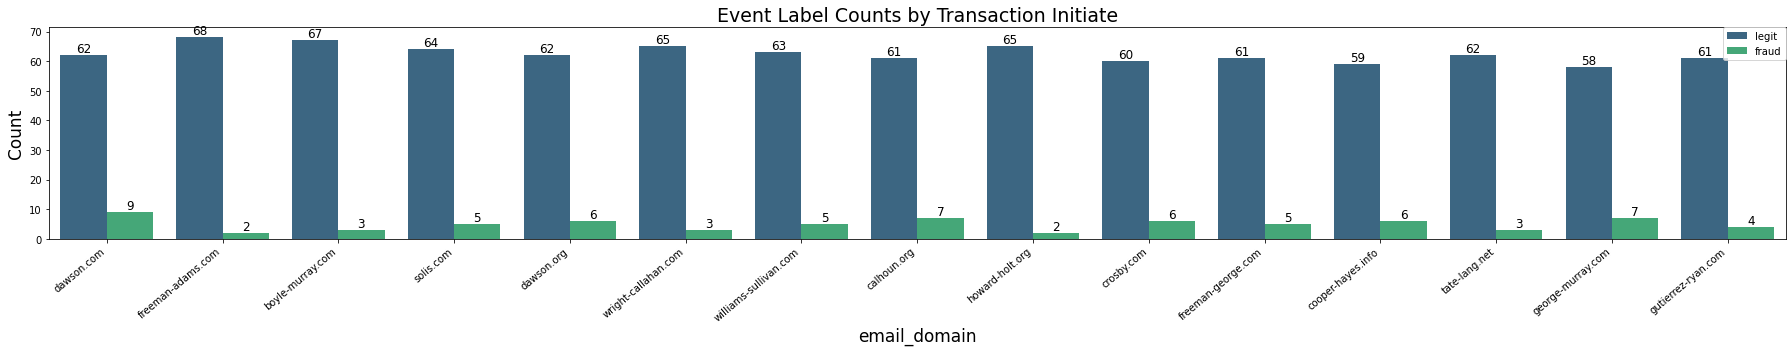

In [34]:
countplot_viz(
    df_data,
    "email_domain",
    "email_domain",
    "Count",
    "Event Label Counts by Transaction Initiate",
    hue="EVENT_LABEL",
    rotation=45,
    figsize_x=25,
    figsize_y=5,
)

### CVV & Event Label:  

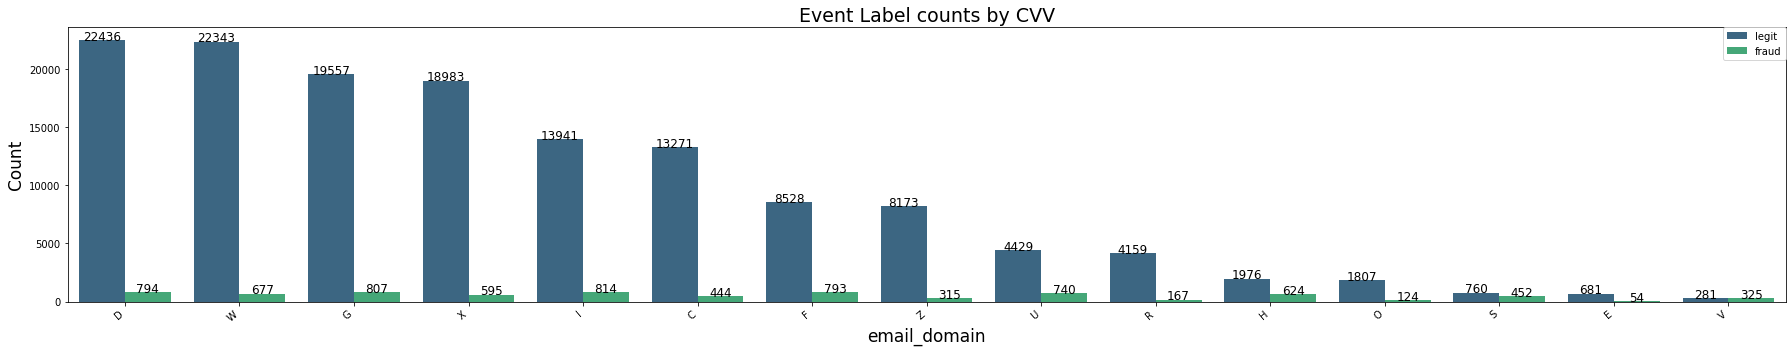

In [35]:
countplot_viz(
    df_data,
    "cvv",
    "email_domain",
    "Count",
    "Event Label counts by CVV",
    hue="EVENT_LABEL",
    rotation=45,
    figsize_x=25,
    figsize_y=5,
)

### Signature Image & Event Label:  

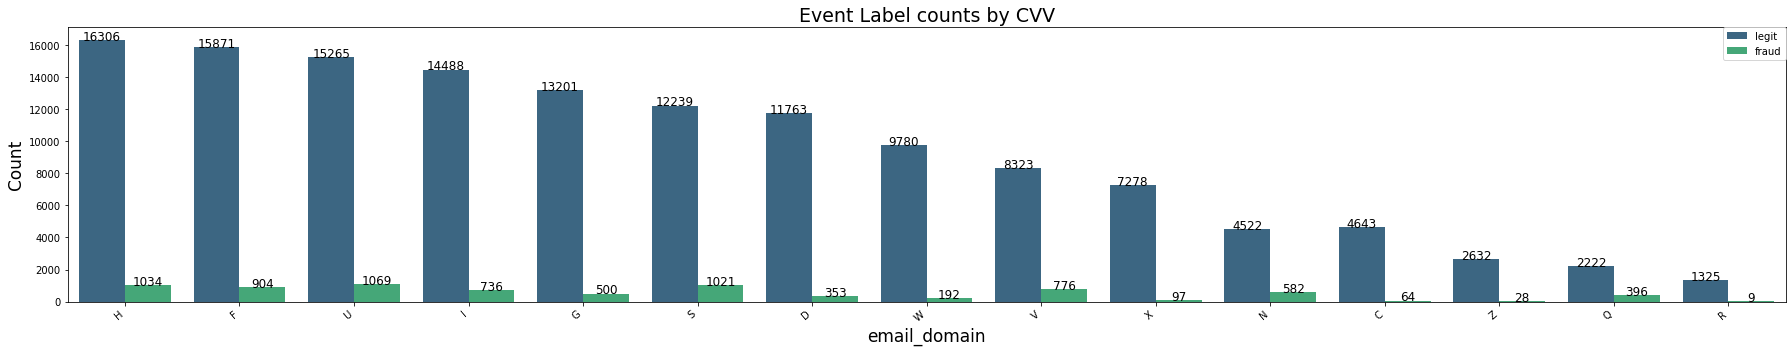

In [36]:
countplot_viz(
    df_data,
    "signature_image",
    "email_domain",
    "Count",
    "Event Label counts by CVV",
    hue="EVENT_LABEL",
    rotation=45,
    figsize_x=25,
    figsize_y=5,
)